At the end of the experiment, you will be able to:

* Understand how to implement MLP using PyTorch to run on GPU



Handwriting changes person to person. Some of us have neat handwriting and some have illegible handwriting such as doctors. However, if you think about it even a child who recognizes alphabets and numerics can identify the characters of a text even written by a stranger. But even a technically knowledgeable adult cannot describe the process by which he or she recognizes the text/letters. As you know this is an excellent challenge for Machine Learning.

![altxt](https://i.pinimg.com/originals/f2/7a/ac/f27aac4542c0090872110836d65f4c99.jpg)

The experiment handles a subset of text recognition, namely recognizing the 10 numerals (0 to 9) from scanned images.


In [ ]:
## Importing required packages
%matplotlib inline

### Importing torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Importing python packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Initializing CUDA

CUDA is used as an interface between our code and the GPU.

Normally, we run the code in the CPU. To run it in the GPU, we need CUDA. Check if CUDA is available:

In [ ]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.4.0 CUDA: True


If it's False, then we run the program on CPU. If it's True, then we run the program on GPU.

Let us initialize some GPU-related variables:

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [ ]:
### Initializing batch size
batch_size = 32

#### 2. Load MNIST data

Now, we'll load the MNIST data. For the first time, we may have to download the data, which can take a while.

In [ ]:
## Loading the train set file
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, 
    #**kwargs
    )

## Loading the test set file
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, 
    #**kwargs
    )


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


The train and test data are provided via data loaders that provide iterators over the datasets.

The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


#### Plotting the  first 10 training digits

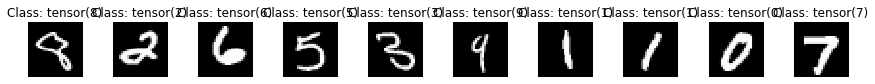

In [ ]:
pltsize=1
plt.figure(figsize=(15*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

#### 3. Define the neural network and optimizer

Let's define the network as a Python class.

When we write the **\__init__()** and **forward()** methods, PyTorch automatically generates a **backward()** method for computing the gradients for the backward pass.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))#Why do we sometimes use F. and sometimes nn.? You could refer the following link: https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

Let us declare an object of class Net, and make it a CUDA model if CUDA is available:

In [ ]:
model = Net()
model = model.to(device)

In [ ]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


Finally, we define an optimizer to update the model parameters based on the computed gradients. We select stochastic gradient descent (with momentum) as the optimization algorithm, and set learning rate to 0.01. Note that there are several different options for the optimizer in PyTorch that we could use instead of SGD.

Let us define the Optimizer as SGD:

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

#### 4. Train the model
Let's now define functions to train() and test() the model.

In [ ]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
       
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using test():

In [ ]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).to(device).sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

Let us compute the time it takes to run this, so as to compare the GPU's performance time with that of CPU.

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312829
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.511775
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.893586
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.748517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.660164
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.598662
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.579729
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.599706
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.434824
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.669976
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.717391
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.755155
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.404582
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.158953
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.238387
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.440815
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.745761
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.370205
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.400477

Test set: Average loss: 0.2385, Accuracy: 9275/10000 (93%)

Thus, GPU is much faster!

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.

Text(0, 0.5, 'error')

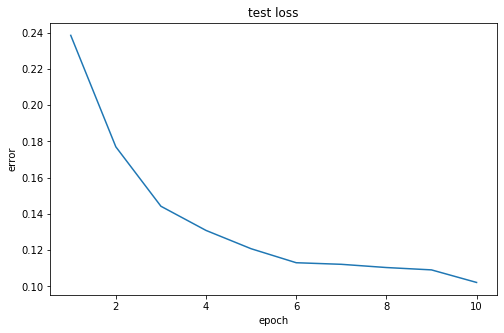

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')
plt.xlabel("epoch")
plt.ylabel("error")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.048006
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.387426
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.139197
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.132517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.029456
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.183269
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.040355
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.145864
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.089939
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.233290
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.505831
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.148043
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.193958
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.038382
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.063271
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.037014
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.044605
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.164386
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.147160

Test set: Average loss: 0.0873, Accuracy: 9734/10000 (97%)

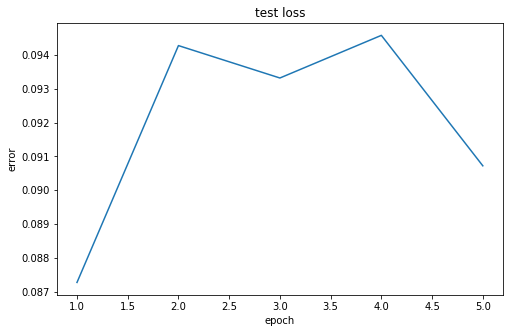

In [ ]:

%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs +
                   1):
    train(epoch)
    test(lossv, accv)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')
plt.xlabel("epoch")
plt.ylabel("error")